In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
from datetime import date,timedelta

df = pd.read_csv('covid_us.csv')
df.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

plt.rcParams['figure.figsize']=(12,6)
plt.style.use('ggplot')

In [2]:
df_American_Samoa = df[df['subregion1_name'] == 'American Samoa'].index.tolist()
df_District_of_Columbia = df[df['subregion1_name'] == 'District of Columbia'].index.tolist()
df_Guam = df[df['subregion1_name'] == 'Guam'].index.tolist()
df_Northern_Mariana_Islands = df[df['subregion1_name'] == 'Northern Mariana Islands'].index.tolist()
df_Puerto_Rico = df[df['subregion1_name'] == 'Puerto Rico'].index.tolist()
df_Virgin_Islands = df[df['subregion1_name'] == 'Virgin Islands'].index.tolist()
df.drop(df_American_Samoa, inplace = True)
df.drop(df_District_of_Columbia, inplace = True)
df.drop(df_Guam, inplace = True)
df.drop(df_Northern_Mariana_Islands, inplace = True)
df.drop(df_Puerto_Rico, inplace = True)
df.drop(df_Virgin_Islands, inplace = True)


#remove all subregion1_name not in 50 states

In [3]:
x = sorted(df['subregion1_name'].unique())
d = {'states' : x}
us_states = pd.DataFrame(data = d)

df = df.sort_values(['subregion1_name', 'date'])
df.reset_index(inplace = True)

#df.dtypes

In [4]:
df = df.fillna(0)                                               #replace all columns with NA in df to 0


#df['total_tested'] = df['total_tested'].fillna(0) 
df['total_confirmed'] = df['total_confirmed'].astype(np.int64)



In [5]:
new_date = []
for i in range(df.shape[0]):
    new_date.append(int("".join(df.loc[i, 'date'].split('-'))))
new_date
df['new_date'] = new_date

#df.head()
#df.dtypes

In [6]:
i = 1
ndays = []
for n in range(df.shape[0]):
    if i == 483:
        i = 1
        ndays.append(i)
        i +=1
    else: 
        ndays.append(i)
        i += 1
df['ndays'] = ndays
df['date'] = pd.to_datetime(df['date'])



In [7]:
states_by_indices = []
i = 0

for n in range(df.shape[0]):
    if df.loc[n, 'subregion1_name'] == us_states.loc[i, 'states']:
        states_by_indices.append(i)
    else:
        i += 1
        states_by_indices.append(i)
        
states_by_indices


dict = {}
for i in us_states['states']:
    dict["df_{0}".format(i)] = df[df['subregion1_name'] == i]            #store the df_states inside a dictionary
                                                                         #key is df_states, value is the dataframe associated with that state
#dict["df_West Virginia"]                                                 #example: dict["df_West Virginia"] gets the dataframe for all rows with subregion1_name = West Virginia 

for key in dict:
    dict[key] = dict[key].reset_index()                                  #reset the index of df_states for easier manipulation of data

In [8]:
class LinearRegression:
    def __init__(self):
        self.b = []
        self.X = []     
        return      
    
    def fit(self, x, y, order): 
        
        self.index = 0
        
        self.X = np.c_[np.ones(len(x))]   #initialize X as a matrix having columns of ones. This corresponds to polynomial of order 0
        while True:
            if self.index < order and order != 0:                          #concatenate power of x to original matrices X
                self.index += 1
                self.X = np.c_[self.X, np.power(x, self.index)]
            
            else:
                break
        self.b = np.linalg.inv(self.X.T@self.X)@(self.X.T@y)           # w = (X^T*X)^-1*(X^T*y) Formula given in lecture
        
        
        return self.X, self.b
    
    def predict(self):
        
        predict_array = self.X@self.b                  #prediction array is just X*w
        
        return predict_array
    
    def mse(self, y, predict_array):
        
        self.mse_array = y - predict_array
        
        self.mse = np.power(self.mse_array, 2)
        
        return np.sum(self.mse)/len(y)

In [9]:
def FitOrder(x,y):                                                #optimization for finding the order that corresponds with minimum mse
    new_order = []
    for i in range(310):
        linear = LinearRegression()
        linear.fit(x,y,i)
        prediction = linear.predict()
        new_order.append(linear.mse(y,prediction))
    index_order = new_order.index(min(new_order))
    return index_order

In [10]:
def StateLinearRegression(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    
    for i in list(df.columns):
        if i == input_col:
            y = np.array(df_state[i][start_day:end_day+1])
            break
    #y = np.array(df_state['total_confirmed'][:480])
    order = FitOrder(x,y)                                                                            #Used 400 samples as training set
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    b = model.mse(y, n)
    
    plt.rcParams['figure.figsize'] = (12,6)
    plt.scatter(x,y, s = 5, color = 'tab:blue')
    plt.plot(x,n, color = 'r')
    plt.ticklabel_format(style = 'plain')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days')
    plt.ylabel(input_col)
    plt.title("{} Covid-19 Cases".format(state))
    plt.show()
    
    return b, order
    

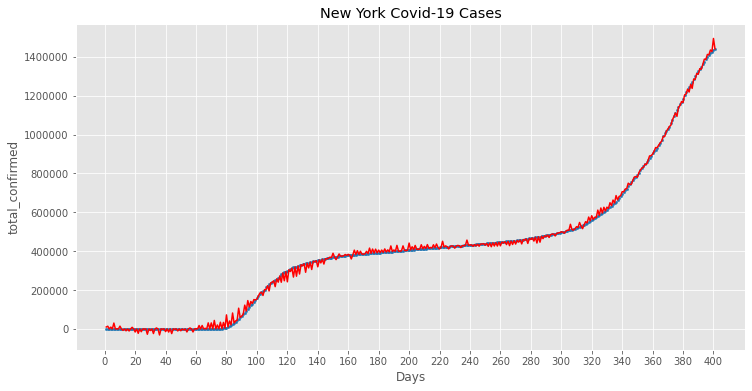

In [11]:
hello = StateLinearRegression("New York", 'total_confirmed', 0, 400)

In [12]:
print("The Mean Square Error is", hello[0], 'and the order of fit is', hello[1])

The Mean Square Error is 226285517.73521888 and the order of fit is 261


In [13]:
def PlotBar(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
        
    plt.rcParams['figure.figsize'] = (12,6)
    plt.bar(list(x), list(y), color='tab:blue')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days', size = 10)
    plt.ylabel(input_col, size = 10)
    plt.title("{0}'s Bar plot of Days vs {1}".format(state, input_col), size = 10)
    plt.show()
    

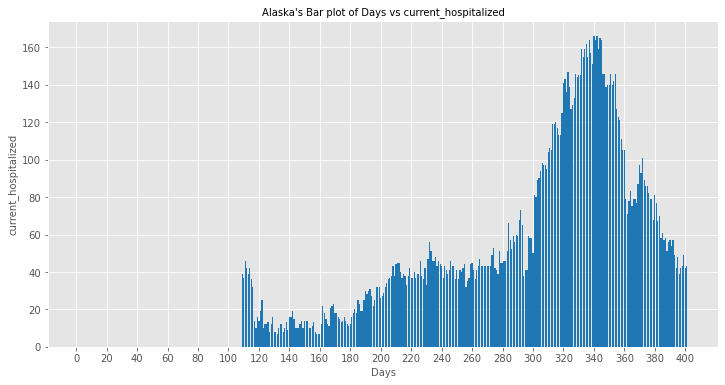

In [14]:
PlotBar("Alaska", 'current_hospitalized', 1, 400)

In [15]:
def BarAndRegression(state, input_col, start_day, end_day):
    PlotBar(state, input_col, start_day, end_day)
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
    
    order = FitOrder(x,y)
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    plt.plot(x,n, color = 'r')
    plt.title("{0}'s Bar plot and Regression of Days vs {1}".format(state, input_col), size = 10)
    plt.show()

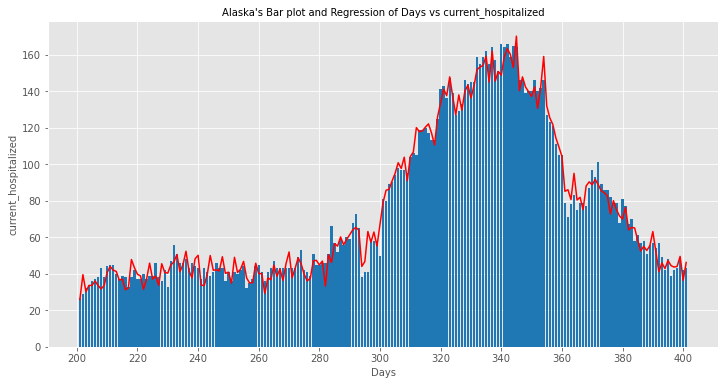

In [16]:
BarAndRegression("Alaska", 'current_hospitalized', 200, 400)

In [77]:
def Stateinfo(state, day):                                         #Display the info at a specific state and day
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    df_new = df_state[df_state['ndays']==day ]
    #df_new = pd.DataFrame.transpose(df_new)
    df_new = df_new.T
    df_new.rename({day-1:state}, axis = 1, inplace = True) 
    
    df_new.drop('level_0', inplace = True)
    df_new.drop('country_name', inplace = True)
    df_new.drop('index', inplace = True)
    df_new.drop('new_date', inplace = True)
    df_new.drop('population_age_00_09', inplace = True)
    df_new.drop('population_age_10_19', inplace = True)
    df_new.drop('population_age_20_29', inplace = True)
    df_new.drop('population_age_30_39', inplace = True)
    df_new.drop('population_age_40_49', inplace = True)
    df_new.drop('population_age_50_59', inplace = True)
    df_new.drop('population_age_60_69', inplace = True)
    df_new.drop('population_age_70_79', inplace = True)
    df_new.drop('population_age_80_89', inplace = True)
    df_new.drop('population_age_90_99', inplace = True)
    df_new.drop('population_age_80_and_older', inplace = True)
    df_new.drop('locality_name', inplace = True)
    df_new.drop('subregion1_name', inplace = True)
    df_new.drop('population_male', inplace = True)
    df_new.drop('population_female', inplace = True)
    df_new = df_new[df_new[state]!=0]
    
    return df_new

In [81]:
Stateinfo('New York', 100)

,New York
date,2020-04-09 00:00:00
new_confirmed,10621
new_deceased,799
new_tested,26396
total_confirmed,159937
total_deceased,7067
total_tested,391549
new_hospitalized,2870
total_hospitalized,42852
current_hospitalized,18279


In [97]:
class TimeSeriesForecast:
    
    def __init__(self):    
        
        self.viz_df =[]
        self.last_date = []
        self.df_state = []
        self.prediction = []
        self.forecast = []
        self.state = []
        self.input_col = []
        
        return   
   
    def Statepredict(self, state, input_col):
        for key in dict:
            if dict[key]['subregion1_name'][0] == state:
                self.df_state = dict[key]
                break
        
        self.state = state
        self.input_col = input_col
        self.df_state = self.df_state = self.df_state[['date', input_col]]
        self.df_state.columns = ['ds', 'y']
        model = Prophet()
        model.fit(self.df_state) 
        future_dates = model.make_future_dataframe(periods = 100)          #adding 100 days/datetime to the dataframe
        self.prediction = model.predict(future_dates)
        self.df_state.set_index('ds', inplace=True)
        self.last_date = self.df_state.index[-1]
        self.prediction.set_index('ds', inplace=True)
        self.df_table = self.df_state.join(self.prediction[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    
    def plot_data(self):
        self.last_date = self.last_date - timedelta(weeks=4) 
        forecast_index= (self.df_table.index > self.last_date) #  pull out the predicted/forecast rows of data.
        self.forecast = self.df_table.loc[forecast_index]       # create a new dataframe with predicted/forecast data.
        
        fig, ax1 = plt.subplots()
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.plot(self.df_state.y[:453])
        ax1.plot(self.prediction.yhat)
        ax1.plot(self.forecast.yhat, color='purple')
        
        ax1.fill_between(self.forecast.index, self.forecast['yhat_upper'], self.forecast['yhat_lower'], alpha=0.5, color='darkgrey')
        
        ax1.set_ylabel(self.input_col)
        ax1.set_xlabel('Date')
        ax1.set_title("{0}: Datetime vs {1} forecast plot".format(self.state, self.input_col))
        ax1.legend(['original data', 'prediction', 'forecast']) 
    

In [98]:
def CallTimeSeriesForecast(state, input_col):
    mod = TimeSeriesForecast()
    mod.Statepredict(state, input_col)
    mod.plot_data()
    return mod.prediction

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


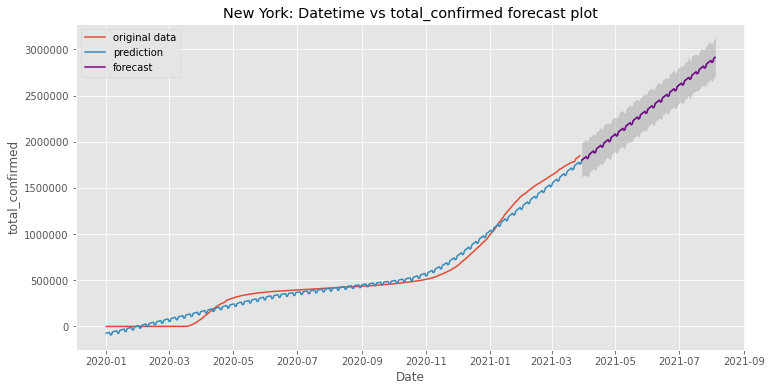

In [118]:
model = CallTimeSeriesForecast('New York', 'total_confirmed')

In [120]:
# import numpy as np, pandas as pd
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# # Original Series
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
# plot_acf(df.value, ax=axes[0, 1])

# # 1st Differencing
# axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
# axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

# plt.show()
